# Project Overview
The aim of this project is to explore and understand the underlying structure within a collection of music tracks from Spotify. By employing community detection algorithms, we seek to uncover natural groupings or communities of tracks based on their musical features, such as genre, popularity, and acoustic characteristics. These insights can enhance music recommendation systems, inform genre classification efforts, and contribute to a deeper understanding of musical trends and relationships.

Dataset Source: The dataset for this analysis is sourced from the Hugging Face ("maharshipandya/spotify-tracks-dataset"). This dataset comprises a wide array of music tracks from Spotify, including attributes such as genre, popularity, duration, and various acoustic features

Project Activities Summary::
- **Data Normalization**: Utilized MinMaxScaler to normalize selected musical features such as popularity, duration, loudness, and tempo, making the data suitable for comparison and analysis.
- **Genre Filtering**: Selected tracks based on specific genres to focus the analysis, ensuring that only relevant data was included in the community detection process.
- **Shuffling and Feature Selection**: Randomly shuffled the dataset to prevent any bias and selected pertinent features to create a feature vector for each track.
- **Cosine Similarity Calculation**: Computed the cosine similarity matrix among tracks to quantify the similarity between each pair based on their features.
- **Graph Construction**: Created an undirected graph where each node represents a track, adding edges between tracks based on a threshold of cosine similarity, effectively linking tracks with high similarity.
- **Community Detection Algorithms** 
    - **Louvain Method**: Applied the Louvain algorithm to the constructed graph to detect communities, adjusting the resolution parameter as necessary to influence the granularity of detected communities.
    - **Girvan-Newman Algorithm**: Utilized the Girvan-Newman algorithm to detect communities by iteratively removing edges based on betweenness centrality, providing insights into the community structure of the music tracks.
- **Evaluation of Community Detection**:
    - Utilized metrics such as Normalized Mutual Information (NMI) and Adjusted Rand Index (ARI) to evaluate the effectiveness of the community detection algorithm by comparing detected communities against the true genres of the tracks.
    - Purity Calculation: Calculated the purity of each community based on the distribution of genres, providing insight into the homogeneity and thematic focus of each community.
    - Genre Distribution Analysis: Analyzed the distribution of genres within and across detected communities to understand the predominant genres and assess the spread and concentration of genres in each community.
    - Average Genre Purity: Calculated the average purity of each genre across all communities to evaluate the consistency of genre representation within communities.

Visualization: Generated visualizations to illustrate the network structure, community distribution, and genre homogeneity, enhancing the interpretability of the community detection results.

In [0]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.style as style
import pandas as pd
import random
import json
import numpy as np
import itertools
!pip install networkx
import networkx as nx
import matplotlib.pyplot as plt
!pip install datasets
from datasets import load_dataset
!pip install scikit-learn
from sklearn.metrics.pairwise import cosine_similarity
!pip install cdlib
from cdlib import algorithms  # Community Detection Library (cdlib)
from networkx.algorithms.community import girvan_newman  # Community Detection Algorithm (Girvan-Newman)

# Import Spotify Dataset

In [147]:
# df
dataset = load_dataset("maharshipandya/spotify-tracks-dataset")
df = pd.DataFrame(dataset['train'])

Normalize selected musical features within a dataset using MinMaxScaler for better comparability and visualization.

In [148]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

features = ['popularity', 'duration_ms', 'loudness', 'tempo']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the features to a range between 0 and 1 for uniformity
df[features] = scaler.fit_transform(df[features])

# Check the first few rows to see the normalized data
df[['track_id', 'popularity', 'duration_ms', 'loudness', 'tempo']].head(5)


,track_id,popularity,duration_ms,loudness,tempo
0,5SuOikwiRyPMVoIQDJUgSV,0.73,0.044043,0.791392,0.361245
1,4qPNDBW1i3p13qLCt0Ki3A,0.55,0.028566,0.597377,0.318397
2,1iJBSr7s7jYXzM8EGcbK5b,0.57,0.040255,0.736123,0.313643
3,6lfxq3CG4xtTiEg7opyCyx,0.71,0.038557,0.573701,0.746758
4,5vjLSffimiIP26QG5WcN2K,0.82,0.037969,0.737103,0.492863


Filter a music dataset to include only selected genres, then randomly samples up to 100 tracks per genre for analysis.


In [149]:
import pandas as pd

selected_genres = [
    "rock", "pop", "electronic", "hip-hop", "jazz",
    "classical", "reggae", "blues", "country", "folk",
    "soul", "metal", "new-age", "industrial"
]

# Filter the DataFrame to only include the selected genres
filtered_df = df[df['track_genre'].isin(selected_genres)]

# Initialize an empty DataFrame to store the selected songs
selected_songs_df = pd.DataFrame()

for genre in selected_genres:
    genre_songs = filtered_df[filtered_df['track_genre'] == genre]
    if len(genre_songs) > 100:
        selected_songs = genre_songs.sample(n=100, random_state=42)  # Ensure reproducibility
    else:
        selected_songs = genre_songs
    selected_songs_df = pd.concat([selected_songs_df, selected_songs], ignore_index=True)

# Reset the index of the DataFrame
selected_songs_df.reset_index(drop=True, inplace=True)

selected_songs_df[['track_id', 'track_name', 'artists', 'track_genre', 'popularity', 'duration_ms', 'loudness', 'tempo']].head(5)


,track_id,track_name,artists,track_genre,popularity,duration_ms,loudness,tempo
0,2Wzl4bZLjqFUOeZaGrTaVJ,parents,YUNGBLUD,rock,0.00,0.032846,0.836432,0.337097
1,1UEj7RpdqH02grDvdxTKLP,"Merry Christmas, Kiss My Ass",All Time Low,rock,0.00,0.038045,0.860052,0.526084
2,3SCYKwSFwlSe5xEvVlcP1W,Jingle Bell Rock,George Strait,rock,0.01,0.025298,0.804432,0.497321
3,1NhPKVLsHhFUHIOZ32QnS2,Secrets,OneRepublic,rock,0.76,0.042902,0.801065,0.608209
4,1ihSSnA4d0dcxQouy7gtNJ,Es Por Ti,Juanes,rock,0.00,0.047948,0.803969,0.533969


### Feature Engineering
Shuffle the dataset for randomization and create a feature vector excluding non-numeric columns.

In [150]:
# Shuffle the DataFrame
df_shuffled = selected_songs_df.sample(frac=1, random_state=42)  # random_state for reproducibility

# Select columns for the feature vector
feature_columns = [
    'track_name', 'popularity', 'duration_ms', 'danceability', 'energy',
    'loudness', 'speechiness', 'acousticness', 'instrumentalness',
    'valence', 'tempo', 'track_genre'
]

# Create a DataFrame with only the selected features
features_df = df_shuffled[feature_columns].reset_index(drop=True)

# Extract numerical features and convert to a NumPy array for modelin
numerical_features_df = features_df.drop(['track_genre', 'track_name'], axis=1)
feature_vectors = numerical_features_df.to_numpy()

features_df


,track_name,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo,track_genre
0,Suena El Dembow,0.00,0.037378,0.690,0.8580,0.834212,0.0529,0.189000,0.000000,0.755,0.377545,reggae
1,X ÚLTIMA VEZ,0.02,0.036751,0.812,0.8550,0.847271,0.0554,0.078900,0.000167,0.573,0.369969,reggae
2,"Kaalathukkum Nee Venum - From ""Vendhu Thanindh...",0.65,0.056049,0.718,0.4580,0.719512,0.0330,0.685000,0.002220,0.567,0.492900,pop
3,Hang Your Lights,0.00,0.056648,0.346,0.6050,0.785602,0.0794,0.188000,0.000000,0.747,0.830724,jazz
4,Orfeo,0.38,0.046874,0.628,0.8230,0.828200,0.0289,0.000074,0.000066,0.824,0.542125,electronic
...,...,...,...,...,...,...,...,...,...,...,...,...
1395,Stormy Weather,0.00,0.035853,0.258,0.3500,0.746962,0.0307,0.716000,0.000000,0.448,0.729525,soul
1396,Teardrinker,0.00,0.061197,0.457,0.9790,0.845218,0.0485,0.000010,0.119000,0.227,0.521860,metal
1397,Nightfall,0.20,0.083639,0.428,0.0653,0.645728,0.0472,0.991000,0.904000,0.214,0.326007,new-age
1398,Christmas Makes Me Cry - From The Kacey Musgra...,0.00,0.035013,0.506,0.2100,0.684331,0.0569,0.808000,0.000000,0.414,0.428073,country


Compute the cosine similarity matrix from the feature vectors to measure the similarity between tracks.

In [151]:
# Compute the cosine similarity matrix
cosine_sim_matrix = cosine_similarity(feature_vectors)

print("Shape of cosine similarity matrix:", cosine_sim_matrix.shape)
print("\nSample of the cosine similarity matrix:\n", cosine_sim_matrix[:5, :5])


Shape of cosine similarity matrix: (1400, 1400)

Sample of the cosine similarity matrix:
 [[1.         0.98851759 0.83376075 0.92389882 0.96143199]
 [0.98851759 1.         0.81808241 0.89235385 0.95295425]
 [0.83376075 0.81808241 1.         0.80878668 0.86358401]
 [0.92389882 0.89235385 0.80878668 1.         0.92795423]
 [0.96143199 0.95295425 0.86358401 0.92795423 1.        ]]


Compute the Pearson correlation matrix

In [152]:
# Transpose the numerical features DataFrame
df_transposed = numerical_features_df.T

# Compute Pearson correlation matrix
cosine_sim_matrix = df_transposed.corr(method='pearson')
cosine_sim_matrix = cosine_sim_matrix.to_numpy()

# Inspect the shape and a portion of the matrix
print("Shape of Pearson correlation matrix:", cosine_sim_matrix.shape)
print("\nSample of the Pearson correlation matrix:\n", cosine_sim_matrix[:5, :5])


Shape of Pearson correlation matrix: (1400, 1400)

Sample of the Pearson correlation matrix:
 [[1.         0.97637951 0.58648559 0.83222467 0.91388312]
 [0.97637951 1.         0.56892388 0.77043562 0.90062693]
 [0.58648559 0.56892388 1.         0.50642573 0.63200062]
 [0.83222467 0.77043562 0.50642573 1.         0.83412989]
 [0.91388312 0.90062693 0.63200062 0.83412989 1.        ]]


Below code retrieves and ranks the similarity scores for a specified track from a pre-computed cosine similarity matrix.

In [153]:
# Initialize the track ID of interest
track_id = 1

# Get the similarity scores for this track and all others
sim_scores = list(enumerate(cosine_sim_matrix[track_id]))

# Sort the tracks based on the similarity scores
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

# Get the scores of the 5 most similar tracks (excluding the first one, which is the track itself)
most_similar_tracks = sim_scores[15:22]

# Display the most similar tracks and their corresponding similarity scores
print("Most similar tracks to track ID 0 and their similarity scores:")
for i, score in most_similar_tracks:
    print(f"Track ID: {i}, Similarity Score: {score:.2f}")


Most similar tracks to track ID 0 and their similarity scores:
Track ID: 754, Similarity Score: 0.99
Track ID: 326, Similarity Score: 0.99
Track ID: 203, Similarity Score: 0.99
Track ID: 1288, Similarity Score: 0.99
Track ID: 988, Similarity Score: 0.99
Track ID: 696, Similarity Score: 0.99
Track ID: 84, Similarity Score: 0.99


## Network Creation
Creates an undirected graph to represent relationships between tracks based on their similarity scores.

In [154]:
%%time
# Initialize an undirected graph
G = nx.Graph()

# Add nodes to the graph, each representing a track and its genre as a node attribute
for i in range(len(features_df)):
    G.add_node(i, genre=features_df.loc[i, 'track_genre'])

# Add edges based on cosine similarity threshold
for i in range(cosine_sim_matrix.shape[0]):
    # Ensure i < j to avoid self-loops and duplicate edges
    for j in range(i + 1, cosine_sim_matrix.shape[1]):
        # Add an edge with the similarity score as the edge weight
        if cosine_sim_matrix[i, j] > 0.98:
            G.add_edge(i, j, weight=cosine_sim_matrix[i, j])

# Find connected components
connected_components = list(nx.connected_components(G))

# Largest connected component
largest_component = max(connected_components, key=len)

# Create a new graph with only the largest component
G_filtered_largest_gcc = G.subgraph(largest_component)

print("Graph Information")
print("------------------")
print(f"Number of nodes: {G_filtered_largest_gcc.number_of_nodes()}")
print(f"Number of edges: {G_filtered_largest_gcc.number_of_edges()}")

Graph Information
------------------
Number of nodes: 843
Number of edges: 6573
CPU times: user 295 ms, sys: 1.08 s, total: 1.37 s
Wall time: 217 ms


### Visualize the graph

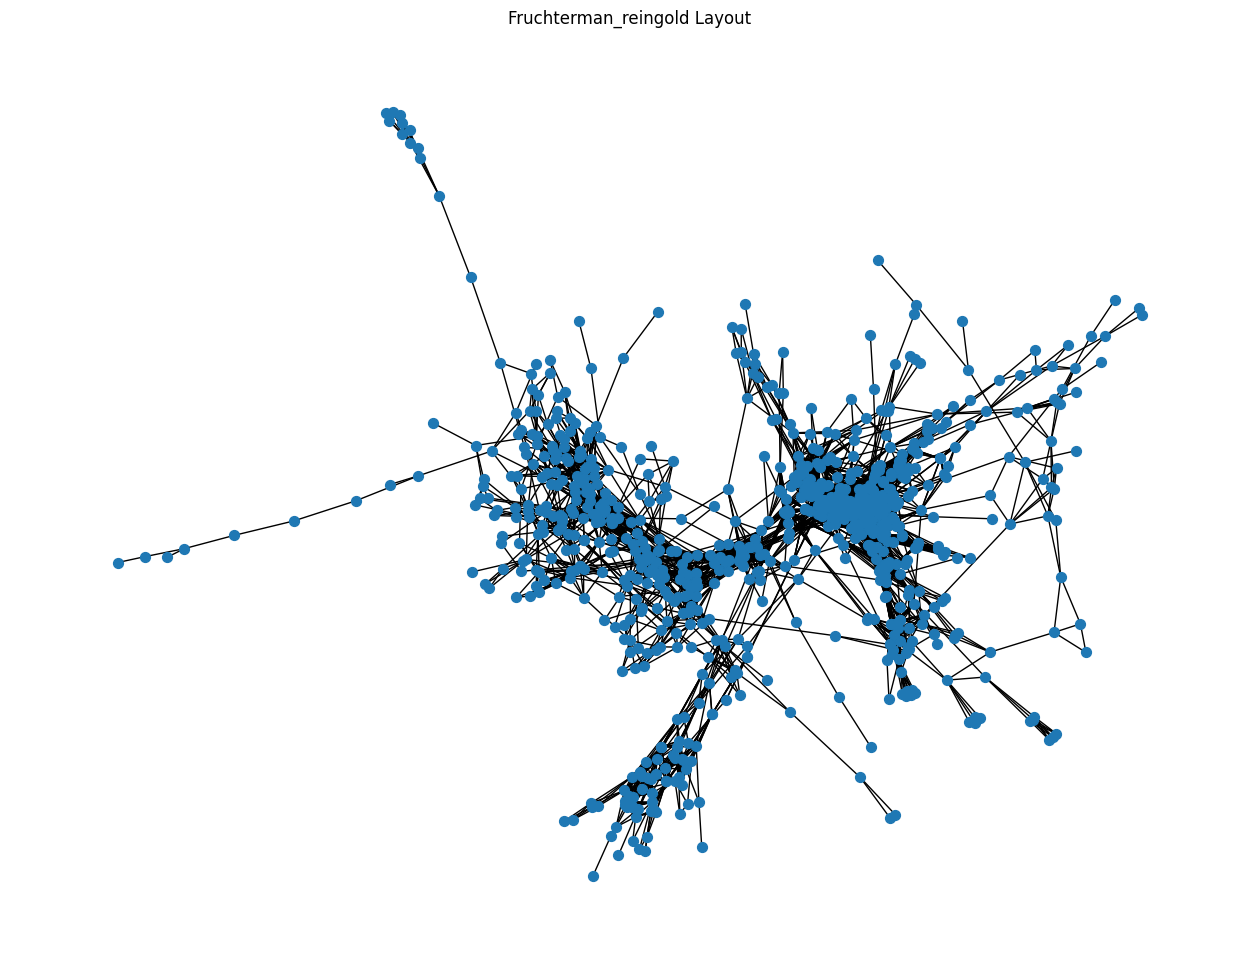

In [155]:
# Apply different layouts
layouts = {
    'fruchterman_reingold': nx.fruchterman_reingold_layout(G_filtered_largest_gcc)
}

# Plotting the graph
for name, layout in layouts.items():
    plt.figure(figsize=(16, 12))
    plt.title(f'{name.capitalize()} Layout')
    nx.draw_networkx(G_filtered_largest_gcc, pos=layout, with_labels=False, node_size=50)
    plt.axis('off')
    plt.show()


# Community Detection 

## Method 1: Louvain Algorithm
This code snippet applies the Louvain algorithm using cdlib library for community detection on a graph G, with the ability to adjust the detection granularity through the resolution parameter. The resulting communities are then mapped to a partition dictionary for easy use in subsequent analyses, such as evaluating the number of detected communities or visualizing the community structure.

Number of communities detected: 13


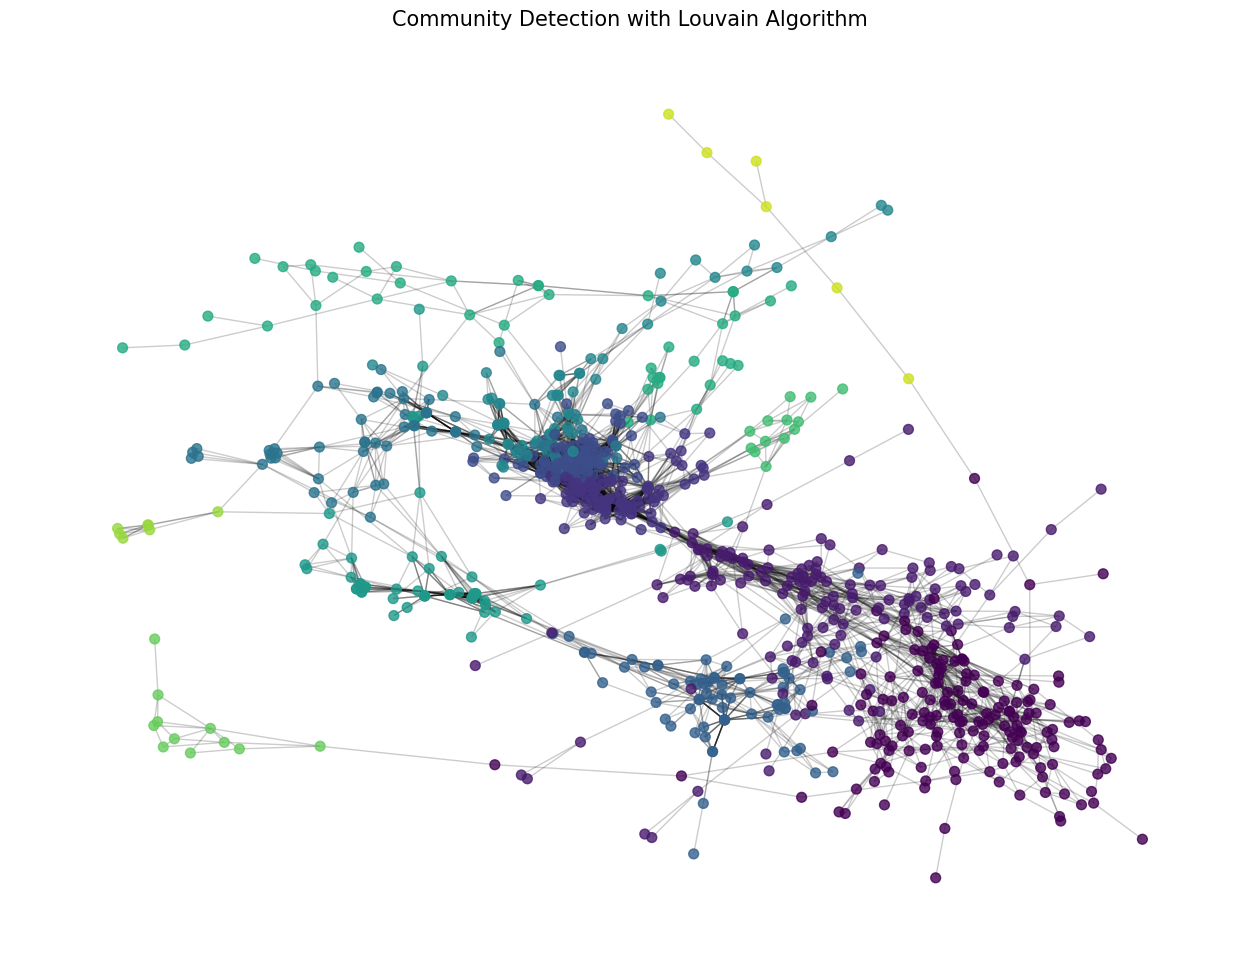

In [183]:
# Apply the Louvain method with a specific resolution. The 'resolution' parameter influences the size of the detected communities; adjust as necessary
communities = algorithms.louvain(G_filtered_largest_gcc, resolution=1)

# communities object contains the partition information
# To match the previous approach, you might want to convert it into a similar structure
partition = {node: cid for cid, community in enumerate(communities.communities) for node in community}

# Calculate the total number of unique communities detected
num_communities = len(set(partition.values()))

# Print the number of detected communities
print(f"Number of communities detected: {num_communities}")

# Visualize the community structure
community_ids = [partition[node] for node in G_filtered_largest_gcc.nodes()]  # Map nodes to their community IDs

# Generate node colors based on their community ID
cmap = plt.get_cmap('viridis')
colors = [cmap(i / num_communities) for i in community_ids]

# Position nodes using the Spring layout
pos = nx.spring_layout(G)

# Draw the graph
plt.figure(figsize=(16, 12))
nx.draw_networkx_nodes(G_filtered_largest_gcc, pos, node_color=colors, node_size=50, alpha=0.8)
nx.draw_networkx_edges(G_filtered_largest_gcc, pos, alpha=0.2)
plt.title("Community Detection with Louvain Algorithm", fontsize=15)
plt.axis('off')
plt.show()


### Evaluate Community Purity
Calculates the "purity" of each community detected in a network graph, with the aim of assessing how homogeneously communities are formed based on genres. 

In [157]:

# Create a dictionary to map each node to its genre
node_to_genre = {i: genre for i, genre in enumerate(features_df['track_genre'])}

# Calculate purity for each community
purity_dict = {}
for community_id in set(partition.values()):
    nodes_in_community = [node for node, com_id in partition.items() if com_id == community_id]
    genres_in_community = [node_to_genre[node] for node in nodes_in_community]
    most_common_genre = max(set(genres_in_community), key=genres_in_community.count)
    purity = genres_in_community.count(most_common_genre) / len(genres_in_community)
    purity_dict[community_id] = purity

# Calculate the overall purity by averaging the purity scores across all communities
overall_purity = sum(purity_dict.values()) / len(purity_dict)

# Print the overall purity
print(f"Overall Cluster Purity: {overall_purity}")


Overall Cluster Purity: 0.3915705074776255


### Evaluate Community Detection Performance using NMI and ARI
Evaluates the effectiveness of a community detection algorithm on a dataset of tracks by comparing the algorithm's community assignments against the tracks' true genres. It uses two metrics for this evaluation: the Normalized Mutual Information (NMI) Score and the Adjusted Rand Index (ARI) Score.

In [158]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
true_labels_encoded = le.fit_transform(features_df['track_genre'])

# Robustly map community labels to tracks, handling any missing or misaligned indices
community_labels_encoded = np.array([partition.get(node, -1) for node in features_df.index])

nmi_score = normalized_mutual_info_score(true_labels_encoded, community_labels_encoded)
ari_score = adjusted_rand_score(true_labels_encoded, community_labels_encoded)

print(f"NMI Score: {nmi_score}")
print(f"ARI Score: {ari_score}")


NMI Score: 0.21632115446502476
ARI Score: 0.06960115078135345


### Analyzing Genre Distribution Across Detected Music Communities
Analyzes the distribution of music genres across the detected communities to understand how genres are grouped together. This analysis can provide insights into the genre-based structure of the music network.

In [159]:
import pandas as pd

# Assuming 'partition' is your community assignment, and 'features_df' contains 'track_genre'
node_to_genre = {i: genre for i, genre in enumerate(features_df['track_genre'])}

# Aggregate genres for each community based on the partitioning result
community_to_genres = {}
for node, community in partition.items():
    if community not in community_to_genres:
        community_to_genres[community] = []
    community_to_genres[community].append(node_to_genre[node])

# Convert the community-genre mapping into a DataFrame for analysis
community_genre_df = pd.DataFrame([(community, genre)
                                   for community, genres in community_to_genres.items()
                                   for genre in genres], columns=['Community', 'Genre'])

# Calculate the distribution of genres within each community
genre_distribution = community_genre_df.groupby(['Community', 'Genre']).size().unstack(fill_value=0)

# Display the genre distribution for each community
print("Genre distribution across communities:")
genre_distribution.head(5)


Genre distribution across communities:


Genre,blues,classical,country,electronic,folk,hip-hop,industrial,jazz,metal,new-age,pop,reggae,rock,soul
Community,,,,,,,,,,,,,,
0,8,0,2,16,7,9,14,0,44,3,10,5,10,5
1,17,0,4,13,10,8,40,1,13,2,5,6,1,4
2,5,0,15,2,3,2,8,1,18,0,7,12,28,7
3,1,0,10,2,1,13,0,1,0,0,6,35,8,9
4,0,8,12,0,8,0,0,33,0,1,3,0,1,11


In [160]:
print("\nGenre distribution in Community 4:")
genre_distribution.iloc[4]


Genre distribution in Community 4:


Genre
blues          0
classical      8
country       12
electronic     0
folk           8
hip-hop        0
industrial     0
jazz          33
metal          0
new-age        1
pop            3
reggae         0
rock           1
soul          11
Name: 4, dtype: int64

In [161]:
print("\nGenre distribution in Community 5:")
genre_distribution.iloc[5]


Genre distribution in Community 5:


Genre
blues         13
classical      0
country        8
electronic     0
folk           4
hip-hop        0
industrial     0
jazz           3
metal          1
new-age        0
pop            9
reggae         2
rock          11
soul          22
Name: 5, dtype: int64

### Evaluate Average Genre Purity in Detected Music Communities
Calculates the purity of each genre within each community and then computes the average purity for each genre across all communities. This measure of purity can help understand how consistently a genre is represented within communities, indicating the presence of genre-centric clusters.

In [162]:
# Calculate purity for each genre in each community
genre_purity = {}
for community in genre_distribution.index:
    for genre in genre_distribution.columns:
        total_in_community = genre_distribution.loc[community].sum()
        genre_count = genre_distribution.loc[community, genre]
        purity = genre_count / total_in_community if total_in_community > 0 else 0
        if genre not in genre_purity:
            genre_purity[genre] = []
        genre_purity[genre].append(purity)

# Calculate average purity for each genre across all communities
average_genre_purity = {genre: np.mean(purities) for genre, purities in genre_purity.items()}

# Display the average purity scores for each genre
print("Average Genre Purity in Detected Communities:")
average_genre_purity


Average Genre Purity in Detected Communities:


{'blues': 0.07320753003252281,
 'classical': 0.011566929802223921,
 'country': 0.10495016377775643,
 'electronic': 0.030406865547887647,
 'folk': 0.04208537173321336,
 'hip-hop': 0.12604999042093512,
 'industrial': 0.037064795412277016,
 'jazz': 0.0731554824427694,
 'metal': 0.09520118803413279,
 'new-age': 0.0034448290815014076,
 'pop': 0.09428544816695826,
 'reggae': 0.0960867136011491,
 'rock': 0.13103446623657428,
 'soul': 0.08146022571009848}

#### Evaluating Genre Homogeneity in Music Track Communities
Analyzes the genre distribution within each community to evaluate the homogeneity of genres in the detected music communities. This analysis can provide insights into how well the communities represent specific genres and whether they are genre-centric or diverse.

In [163]:
# Organize nodes into communities based on their community IDs from the partition
communities = {}
for node, community_id in partition.items():
    communities.setdefault(community_id, []).append(node)

# Initialize a DataFrame to store the selected songs with their community IDs for easier analysis
features_df['community_id'] = features_df.index.map(partition)

# Calculate purity for each genre in communities with more than 5 nodes. Iterate through communities and calculate genre purity for communities with more than one node
genre_purity = {}
for community_id, nodes in communities.items():
    if len(nodes) > 1:  # Check if the community size is greater than 5
        community_df = features_df[features_df['community_id'] == community_id]
        genre_counts = community_df['track_genre'].value_counts()
        total_tracks = sum(genre_counts)
        for genre, count in genre_counts.iteritems():
            purity = count / total_tracks
            genre_purity.setdefault(genre, []).append(purity)

# Calculate average purity for each genre across all communities
average_genre_purity = {genre: np.mean(purities) for genre, purities in genre_purity.items()}

# Display the average genre purity for communities with more than one node
print("Average Genre Purity in Communities with More than 5 Nodes:")
for genre, purity in average_genre_purity.items():
    print(f"\t- {genre}: {purity:.2f}")


Average Genre Purity in Communities with More than 5 Nodes:
	- metal: 0.18
	- electronic: 0.09
	- industrial: 0.14
	- rock: 0.15
	- pop: 0.12
	- hip-hop: 0.21
	- blues: 0.11
	- folk: 0.05
	- reggae: 0.13
	- soul: 0.11
	- new-age: 0.02
	- country: 0.13
	- jazz: 0.14
	- classical: 0.06


#### Quantitative Analysis of Genre Distribution in Detected Music Communities
This code block creates a detailed analysis of how well the community detection algorithm has grouped tracks of similar genres together. It calculates the predominant community for each genre, the concentration of genre tracks in the predominant community, and the spread of each genre across different communities.

In [164]:
# Map each track in the features_df to its community based on the previously determined partition
features_df['community'] = features_df.apply(lambda row: partition.get(row.name, np.nan), axis=1)

# Create a DataFrame to evaluate genre distribution across communities
genre_evaluation = pd.DataFrame(index=selected_genres, columns=['Predominant Community', 'Concentration', 'Spread'])

# Analyze each selected genre to determine its distribution and concentration within communities
for genre in selected_genres:
    # Filter tracks of the current genre
    genre_tracks = features_df[features_df['track_genre'] == genre]

    # Find the most common community for this genre
    predominant_community = genre_tracks['community'].mode()[0]

    # Calculate the concentration: proportion of genre tracks in the predominant community
    concentration = np.sum(genre_tracks['community'] == predominant_community) / len(genre_tracks)

    # Calculate the spread: number of unique communities containing this genre
    spread = genre_tracks['community'].nunique()

    # Update the DataFrame
    genre_evaluation.loc[genre] = [predominant_community, concentration, spread]

# Convert the 'Concentration' column to numeric for proper analysis
genre_evaluation['Concentration'] = pd.to_numeric(genre_evaluation['Concentration'])

# Display the genre evaluation metrics
print(genre_evaluation)


           Predominant Community  Concentration Spread
rock                         2.0           0.28     13
pop                          0.0           0.10     12
electronic                   0.0           0.16      5
hip-hop                      3.0           0.13      9
jazz                         4.0           0.33      8
classical                    4.0           0.08      3
reggae                       3.0           0.35     11
blues                        1.0           0.17     10
country                      2.0           0.15     12
folk                         1.0           0.10     12
soul                         5.0           0.22     11
metal                        0.0           0.44      8
new-age                      0.0           0.03      3
industrial                   1.0           0.40      4


## Method 2: Girvan Newman Algorithm
This code applies the Girvan-Newman algorithm to a graph G to detect communities, demonstrating an iterative approach to community detection by edge removal based on betweenness centrality. It then maps each node to its corresponding community ID, providing a simple way to understand the graph's community structure

In [165]:
%%time
# Apply Girvan-Newman algorithm on the filtered largest connected component
communities_generator = girvan_newman(G_filtered_largest_gcc)

# Retrieve the first level of communities as generated by the algorithm
first_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)  # For deeper level

# Convert communities set to a list of lists for easier processing
communities = [list(community) for community in next_level_communities]

# Print the number of detected communities and the first 5 nodes in each community
print(f"Number of communities detected: {len(communities)}")
for i, community in enumerate(communities[:10]):
    # Print the first 5 nodes in each community
    print(f"\t- Community {i + 1} (size {len(community)}): {community[:5]}...")

# The partition dictionary maps each node to its community ID
partition = {}
for cid, community in enumerate(communities):
    for node in community:
        partition[node] = cid

# Recalculate and print the total number of unique communities for clarity
num_communities = len(set(partition.values()))
print(f"\nNumber of communities detected: {num_communities}\n")


Number of communities detected: 3
	- Community 1 (size 383): [0, 1, 3, 5, 14]...
	- Community 2 (size 324): [4, 11, 21, 22, 30]...
	- Community 3 (size 136): [514, 9, 525, 1043, 533]...

Number of communities detected: 3

CPU times: user 3min 5s, sys: 488 ms, total: 3min 6s
Wall time: 3min 8s


### Visualizing Community Detection Results

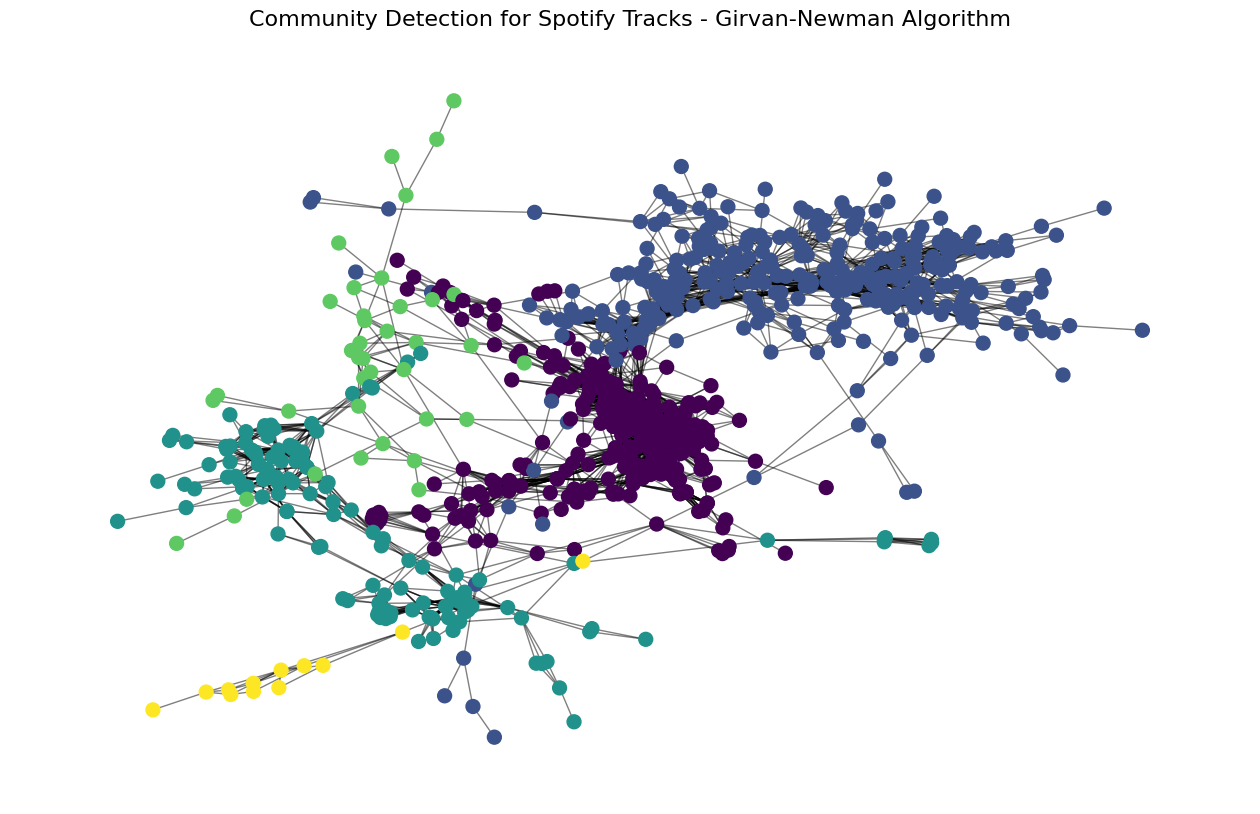

In [166]:
# Retrieve the first level of communities as generated by the algorithm
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)  # For deeper level

# Assume we want to visualize the second level of communities for clarity
communities = sorted(map(sorted, next_level_communities))

# Create a color map for the nodes
color_map = []
for node in G_filtered_largest_gcc.nodes():
    for community_index, community in enumerate(communities):
        if node in community:
            color_map.append(community_index)
            break

# Draw the graph
pos = nx.spring_layout(G_filtered_largest_gcc)
plt.figure(figsize=(16, 10))
nx.draw_networkx_nodes(G_filtered_largest_gcc, pos, node_color=color_map, cmap=plt.cm.viridis, node_size=100)
nx.draw_networkx_edges(G_filtered_largest_gcc, pos, alpha=0.5)
plt.title('Community Detection for Spotify Tracks - Girvan-Newman Algorithm', size=16)
plt.axis('off')
plt.show()

#### Applying Girvan-Newman Algorithm to entire network

In [167]:
%%time
# Apply Girvan-Newman algorithm on the filtered largest connected component
communities_generator = girvan_newman(G)

# Retrieve the first level of communities as generated by the algorithm
first_level_communities = next(communities_generator)

# Convert communities set to a list of lists for easier processing
communities = [list(community) for community in first_level_communities]

# Print the number of detected communities and the first 5 nodes in each community
print(f"Number of communities detected: {len(communities)}")
for i, community in enumerate(communities[:5]):
    # Print the first 5 nodes in each community
    print(f"\t- Community {i + 1} (size {len(community)}): {community[:5]}...")

# The partition dictionary maps each node to its community ID
partition = {}
for cid, community in enumerate(communities):
    for node in community:
        partition[node] = cid

# Recalculate and print the total number of unique communities for clarity
num_communities = len(set(partition.values()))
print(f"\nNumber of communities detected: {num_communities}\n")


Number of communities detected: 337
	- Community 1 (size 707): [0, 1, 3, 4, 5]...
	- Community 2 (size 3): [336, 2, 245]...
	- Community 3 (size 1): [6]...
	- Community 4 (size 9): [865, 677, 7, 139, 1326]...
	- Community 5 (size 1): [8]...

Number of communities detected: 337

CPU times: user 1min 55s, sys: 574 ms, total: 1min 55s
Wall time: 1min 56s


### Evaluating Genre Homogeneity Across Detected Music Communities
The code calculates and displays the overall cluster purity based on genre distribution within detected communities. High purity values indicate that communities are highly homogeneous in terms of genres, which suggests effective community detection in grouping similar music tracks.

In [168]:
# Map nodes to genres
node_to_genre = {i: genre for i, genre in enumerate(features_df['track_genre'])}

# Dictionary to store the purity of each community
purity_dict = {}

# Iterate over each community to calculate its purity
for community_id in set(partition.values()):
    nodes_in_community = [node for node, com_id in partition.items() if com_id == community_id]
    genres_in_community = [node_to_genre[node] for node in nodes_in_community]
    most_common_genre = max(set(genres_in_community), key=genres_in_community.count)
    purity = genres_in_community.count(most_common_genre) / len(genres_in_community)
    purity_dict[community_id] = purity

# Compute the overall purity across all communities by averaging individual purities
overall_purity = sum(purity_dict.values()) / len(purity_dict)

# Print the overall cluster purity to evaluate the homogeneity
print(f"Overall Cluster Purity: {overall_purity}")



Overall Cluster Purity: 0.9409955260668326


### Evaluate Community Detection Performance using NMI and ARI
Evaluates the effectiveness of a community detection algorithm on a dataset of tracks by comparing the algorithm's community assignments against the tracks' true genres. It uses two metrics for this evaluation: the Normalized Mutual Information (NMI) Score and the Adjusted Rand Index (ARI) Score.

In [169]:
le = LabelEncoder()
true_labels_encoded = le.fit_transform(features_df['track_genre'])

community_labels_encoded = np.array([partition[node] for node in range(len(features_df))])

nmi_score = normalized_mutual_info_score(true_labels_encoded, community_labels_encoded)
ari_score = adjusted_rand_score(true_labels_encoded, community_labels_encoded)

print(f"NMI Score: {nmi_score}")
print(f"ARI Score: {ari_score}")


NMI Score: 0.3878265119253189
ARI Score: 0.06145720975265387


### Analyzing Genre Distribution Across Detected Music Communities
Analyzes the distribution of music genres across the detected communities to understand how genres are grouped together. This analysis can provide insights into the genre-based structure of the music network.

In [170]:
import pandas as pd

# Assuming 'partition' is your community assignment, and 'features_df' contains 'track_genre'
node_to_genre = {i: genre for i, genre in enumerate(features_df['track_genre'])}

# Aggregate genres for each community based on the partitioning result
community_to_genres = {}
for node, community in partition.items():
    if community not in community_to_genres:
        community_to_genres[community] = []
    community_to_genres[community].append(node_to_genre[node])

# Convert the community-genre mapping into a DataFrame for analysis
community_genre_df = pd.DataFrame([(community, genre)
                                   for community, genres in community_to_genres.items()
                                   for genre in genres], columns=['Community', 'Genre'])

# Calculate the distribution of genres within each community
genre_distribution = community_genre_df.groupby(['Community', 'Genre']).size().unstack(fill_value=0)

# Display the genre distribution for each community
print("Genre distribution across communities:")
genre_distribution.head(5)



Genre distribution across communities:


Genre,blues,classical,country,electronic,folk,hip-hop,industrial,jazz,metal,new-age,pop,reggae,rock,soul
Community,,,,,,,,,,,,,,
0,52,1,66,40,32,63,64,12,89,5,57,86,75,65
1,0,0,0,0,0,2,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,2,0,2,0,0,2,0,0,1,1,0,1
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0


### Evaluate Average Genre Purity in Detected Music Communities
Calculates the purity of each genre within each community and then computes the average purity for each genre across all communities. This measure of purity can help understand how consistently a genre is represented within communities, indicating the presence of genre-centric clusters.

In [171]:
# Calculate purity for each genre in each community
genre_purity = {}
for community in genre_distribution.index:
    for genre in genre_distribution.columns:
        total_in_community = genre_distribution.loc[community].sum()
        genre_count = genre_distribution.loc[community, genre]
        purity = genre_count / total_in_community if total_in_community > 0 else 0
        if genre not in genre_purity:
            genre_purity[genre] = []
        genre_purity[genre].append(purity)

# Calculate average purity for each genre across all communities
average_genre_purity = {genre: np.mean(purities) for genre, purities in genre_purity.items()}

# Display the average purity scores for each genre
print("Average Genre Purity in Detected Communities:")
average_genre_purity


Average Genre Purity in Detected Communities:


{'blues': 0.06429962922482309,
 'classical': 0.09437824832529385,
 'country': 0.031433101979125425,
 'electronic': 0.15407490727877365,
 'folk': 0.10214939654701576,
 'hip-hop': 0.08089415766502467,
 'industrial': 0.09087197825335734,
 'jazz': 0.05915860986143498,
 'metal': 0.02806889421455923,
 'new-age': 0.09382034237386286,
 'pop': 0.08190706579073737,
 'reggae': 0.030611528723877048,
 'rock': 0.041394766424751095,
 'soul': 0.046937373337363655}

#### Evaluating Genre Homogeneity in Music Track Communities
Analyzes the genre distribution within each community to evaluate the homogeneity of genres in the detected music communities. This analysis can provide insights into how well the communities represent specific genres and whether they are genre-centric or diverse.

In [172]:
# Organize nodes into communities based on their community IDs from the partition
communities = {}
for node, community_id in partition.items():
    communities.setdefault(community_id, []).append(node)

# Initialize a DataFrame to store the selected songs with their community IDs for easier analysis
features_df['community_id'] = features_df.index.map(partition)

# Calculate purity for each genre in communities with more than 5 nodes. Iterate through communities and calculate genre purity for communities with more than one node
genre_purity = {}
for community_id, nodes in communities.items():
    if len(nodes) > 1:  # Check if the community size is greater than 1
        community_df = features_df[features_df['community_id'] == community_id]
        genre_counts = community_df['track_genre'].value_counts()
        total_tracks = sum(genre_counts)
        for genre, count in genre_counts.iteritems():
            purity = count / total_tracks
            genre_purity.setdefault(genre, []).append(purity)

# Calculate average purity for each genre across all communities
average_genre_purity = {genre: np.mean(purities) for genre, purities in genre_purity.items()}

# Display the average genre purity for communities with more than one node
print("Average Genre Purity in Communities with More than 1 Nodes:")
for genre, purity in average_genre_purity.items():
    print(f"\t- {genre}: {purity:.2f}")


Average Genre Purity in Communities with More than 1 Nodes:
	- metal: 0.49
	- reggae: 0.33
	- rock: 0.24
	- country: 0.37
	- soul: 0.26
	- industrial: 0.52
	- hip-hop: 0.53
	- pop: 0.41
	- blues: 0.35
	- electronic: 0.41
	- folk: 0.50
	- jazz: 0.33
	- new-age: 0.37
	- classical: 0.53


In [173]:

# Map each track in the features_df to its community based on the previously determined partition
features_df['community'] = features_df.apply(lambda row: partition.get(row.name, np.nan), axis=1)

# Initialize a DataFrame to store genre evaluation metrics
genre_evaluation = pd.DataFrame(index=selected_genres, columns=['Predominant Community', 'Concentration', 'Spread'])

for genre in selected_genres:
    # Filter tracks of the current genre
    genre_tracks = features_df[features_df['track_genre'] == genre]

    # Find the most common community for this genre
    predominant_community = genre_tracks['community'].mode()[0]

    # Calculate the concentration: proportion of genre tracks in the predominant community
    concentration = np.sum(genre_tracks['community'] == predominant_community) / len(genre_tracks)

    # Calculate the spread: number of unique communities containing this genre
    spread = genre_tracks['community'].nunique()

    # Update the DataFrame
    genre_evaluation.loc[genre] = [predominant_community, concentration, spread]

# Convert the 'Concentration' column to numeric for proper analysis
genre_evaluation['Concentration'] = pd.to_numeric(genre_evaluation['Concentration'])

# Display the genre evaluation metrics
print(genre_evaluation)

           Predominant Community  Concentration Spread
rock                           0           0.75     17
pop                            0           0.57     37
electronic                     0           0.40     59
hip-hop                        0           0.63     32
jazz                           5           0.57     28
classical                     33           0.50     37
reggae                         0           0.86     15
blues                          0           0.52     32
country                        0           0.66     15
folk                           0           0.32     46
soul                           0           0.65     21
metal                          0           0.89     11
new-age                       33           0.59     36
industrial                     0           0.64     34


In [174]:
# Count the occurrences of each genre
genre_counts = features_df['track_genre'].value_counts()

# Display the genre distribution
print(genre_counts)


reggae        100
pop           100
jazz          100
electronic    100
blues         100
country       100
folk          100
hip-hop       100
classical     100
rock          100
soul          100
industrial    100
metal         100
new-age       100
Name: track_genre, dtype: int64


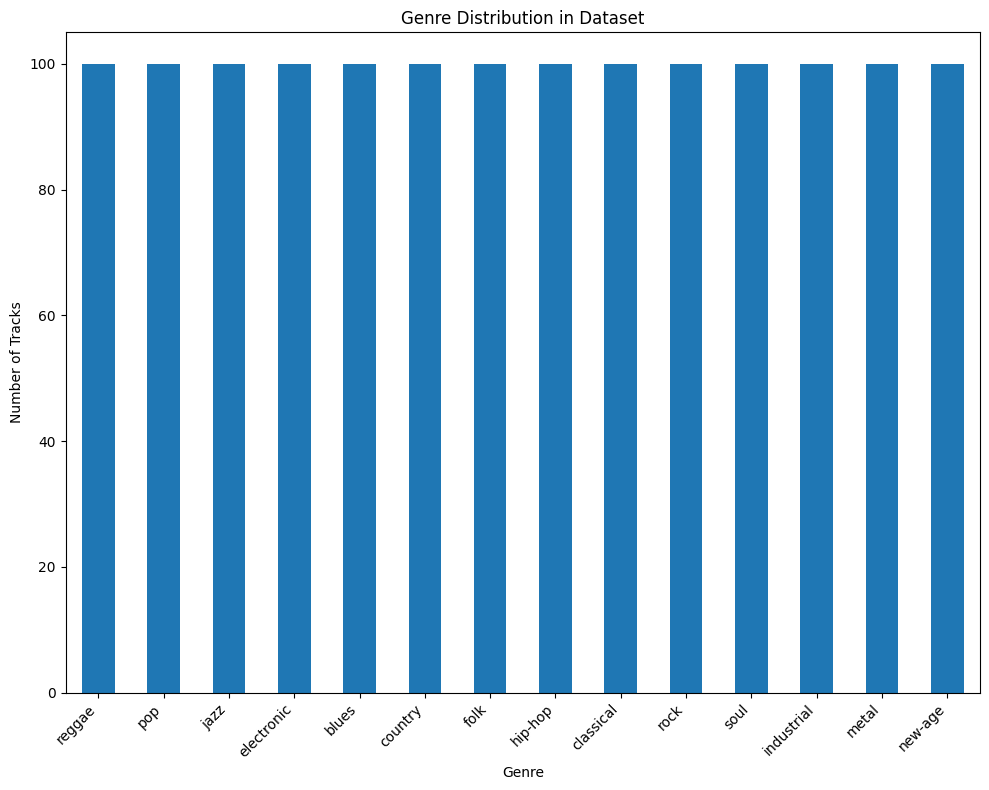

In [175]:
import matplotlib.pyplot as plt

# Plot the genre distribution
plt.figure(figsize=(10, 8))
genre_counts.plot(kind='bar')
plt.title('Genre Distribution in Dataset')
plt.xlabel('Genre')
plt.ylabel('Number of Tracks')
plt.xticks(rotation=45, ha='right')  # Rotate labels to improve readability
plt.tight_layout()  # Adjust layout to make room for the rotated labels
plt.show()


In [176]:

# Get all unique genres
unique_genres = features_df['track_genre'].unique()

# Print all unique genres
print("Unique Genres in the Dataset:")
for genre in unique_genres:
    print("\t- ", genre)


Unique Genres in the Dataset:
	-  reggae
	-  pop
	-  jazz
	-  electronic
	-  blues
	-  country
	-  folk
	-  hip-hop
	-  classical
	-  rock
	-  soul
	-  industrial
	-  metal
	-  new-age


# Additional Work

In [177]:
%%time

# Number of nodes
num_nodes = G.number_of_nodes()

# Number of edges
num_edges = G.number_of_edges()

# Average Node Degree
avg_degree = (2 * num_edges) / num_nodes

# Finding the Giant Connected Component (GCC)
gcc = max(nx.connected_components(G), key=len)

# Create a subgraph from GCC
gcc_subgraph = G.subgraph(gcc)

# Number of nodes in GCC
num_nodes_gcc = gcc_subgraph.number_of_nodes()

# Number of edges in GCC
num_edges_gcc = gcc_subgraph.number_of_edges()

# Diameter of GCC - Uncomment if needed
# Note: Calculation could be very slow for large components.
# if nx.is_connected(gcc_subgraph):
#     diameter_gcc = nx.diameter(gcc_subgraph)
# else:
#     diameter_gcc = None

# Average clustering coefficient
avg_clustering_coefficient = nx.average_clustering(G)

# Print the statistics
print("Filtered Network Statistics:")
print(f"\t- Number of nodes in the filtered network: {num_nodes:,}")
print(f"\t- Number of edges in the filtered network: {num_edges:,}")
print(f"\t- Average Degree of the filtered network: {avg_degree:.2f}")
print(f"\t- Size of the largest interconnected group in GCC (Nodes): {num_nodes_gcc:,}")
print(f"\t- Total connections within the GCC (Edges): {num_edges_gcc:,}")
print(f"\t- Average clustering coefficient of the filtered network: {avg_clustering_coefficient:.5f}")


Filtered Network Statistics:
	- Number of nodes in the filtered network: 1,400
	- Number of edges in the filtered network: 7,131
	- Average Degree of the filtered network: 10.19
	- Size of the largest interconnected group in GCC (Nodes): 843
	- Total connections within the GCC (Edges): 6,573
	- Average clustering coefficient of the filtered network: 0.36866
CPU times: user 173 ms, sys: 3.24 ms, total: 176 ms
Wall time: 58.7 ms


#### Summary: 
The filtered network, representing a subset of the Spotify music tracks based on specific criteria, consists of 1,400 nodes (tracks) connected by 7,131 edges, indicating relationships (e.g., similarity) between the tracks. The average degree, or the average number of connections per node, is 10.19, reflecting a moderately connected network. Within this network, the largest interconnected group, or the Giant Connected Component (GCC), comprises 843 nodes, with a total of 6,573 connections among them, highlighting a core cluster of closely related tracks. The average clustering coefficient, a measure of the degree to which nodes tend to cluster together, is 0.36866, suggesting a moderate level of local clustering within the network. This statistical snapshot provides valuable insights into the network's structure, revealing both its overall connectivity and the tight-knit nature of its largest community.



### Visualizing Network Statistics
This code snippet visualizes the network statistics using bar plots for better understanding and comparison. The log-log plot of node degrees visualizes the frequency distribution of connections per node (degree) within a network on a logarithmic scale for both axes. The histogram and box plot of similarity scores provide insights into the distribution and spread of similarity values between tracks in the network.

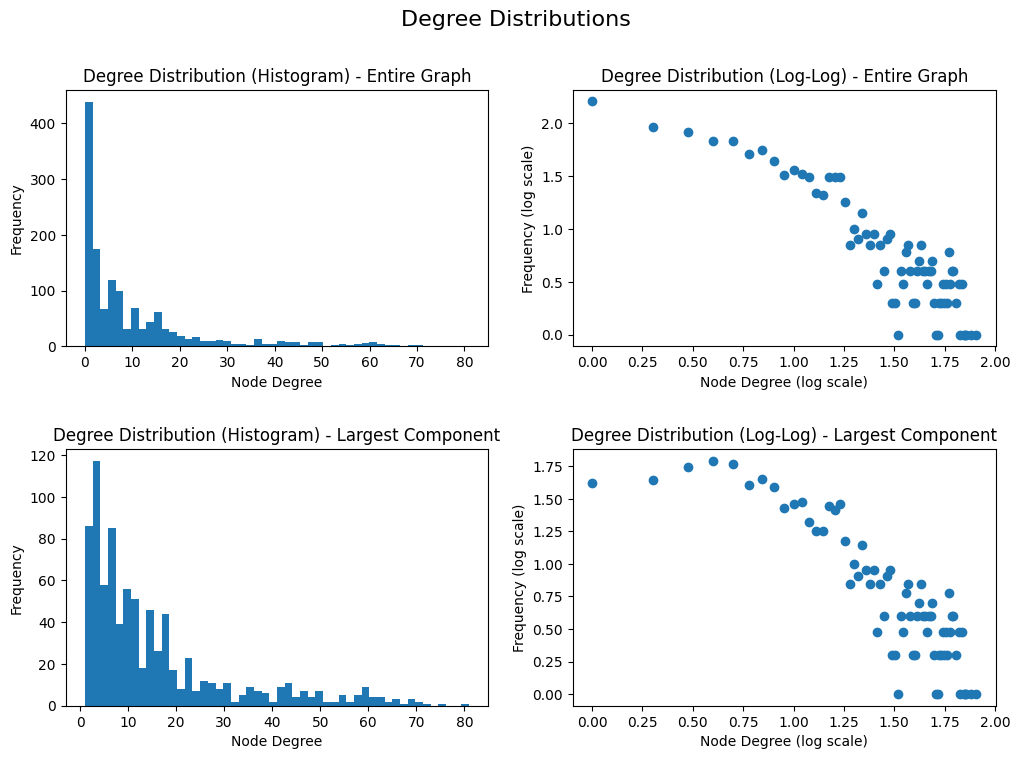

In [186]:
import collections

# Calculate the largest connected component
G_largest_gcc = max(nx.connected_components(G), key=len)
G_largest_gcc = G.subgraph(G_largest_gcc)

# Degree calculations for both graphs
degree_sequence_G = sorted((d for n, d in G.degree()), reverse=True)
degree_count_G = collections.Counter(degree_sequence_G)

degree_sequence_gcc = sorted((d for n, d in G_largest_gcc.degree()), reverse=True)
degree_count_gcc = collections.Counter(degree_sequence_gcc)

# Subplots 
plt.figure(figsize=(12, 8))
plt.suptitle('Degree Distributions', fontsize=16)

# Row 1: Entire Graph (G)
plt.subplot(2, 2, 1)
plt.hist(degree_sequence_G, bins=50)
plt.title('Degree Distribution (Histogram) - Entire Graph')
plt.xlabel('Node Degree')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
log_deg_G = np.log10(list(degree_count_G.keys()))
log_cnt_G = np.log10(list(degree_count_G.values()))
plt.scatter(log_deg_G, log_cnt_G)
plt.title('Degree Distribution (Log-Log) - Entire Graph')
plt.xlabel('Node Degree (log scale)')
plt.ylabel('Frequency (log scale)')

# Row 2: Largest Connected Component (G_largest_gcc)
plt.subplot(2, 2, 3)
plt.hist(degree_sequence_gcc, bins=50)
plt.title('Degree Distribution (Histogram) - Largest Component')
plt.xlabel('Node Degree')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
log_deg_gcc = np.log10(list(degree_count_gcc.keys()))
log_cnt_gcc = np.log10(list(degree_count_gcc.values()))
plt.scatter(log_deg_gcc, log_cnt_gcc)
plt.title('Degree Distribution (Log-Log) - Largest Component')
plt.xlabel('Node Degree (log scale)')
plt.ylabel('Frequency (log scale)')

plt.subplots_adjust(hspace=0.4)
plt.show()



The degree distribution visualizations reflect the structure and connectivity patterns within the Spotify track similarity graph. The histogram plots indicate that most tracks have a low degree, meaning they have a small number of similar tracks within the defined similarity threshold. A few tracks act as hubs with a higher degree, indicating they are similar to many other tracks. The log-log plots provide a clearer view of the degree distribution, showing a power-law relationship in the degree distribution of both the entire graph and the largest connected component. This pattern suggests a scale-free network structure, where a few nodes have a high degree while most nodes have a low degree, highlighting the presence of hubs in the network.

In the context of community detection, this degree distribution is significant. The presence of highly connected hubs suggests that there are popular or musically central tracks that form the core of communities. These tracks likely share strong similarities with others, making them central nodes around which communities are built. Understanding the degree distribution helps identify these central tracks and comprehend the network's overall structure and connectivity patterns.

**Recommendation**: Removing outliers or nodes with very low degrees can sometimes improve community detection by focusing the algorithm on the most significant relationships in the network.

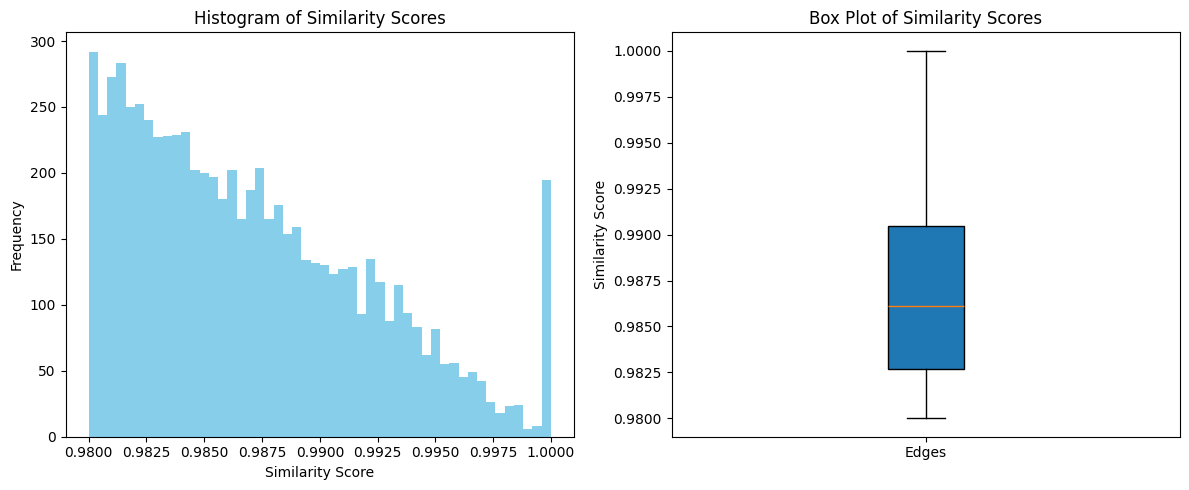

In [180]:
# Assuming G_undirected_optimized is your NetworkX graph
weights = [data['weight'] for _, _, data in G.edges(data=True)]

# Plotting the histogram and box plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(weights, bins=50, color='skyblue')
plt.title('Histogram of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(weights, vert=True, patch_artist=True)
plt.title('Box Plot of Similarity Scores')
plt.ylabel('Similarity Score')
plt.xticks([1], ['Edges'])

plt.tight_layout()
plt.show()


## Feature Importance Analysis

### Random Forest Classifier for Feature Importance
This code snippet uses a Random Forest classifier to determine the feature importances for predicting the genre of a track. It trains the classifier on the selected features and their corresponding genre labels, then extracts the feature importances to identify the most relevant features for genre prediction.

Feature Importances:
	- popularity: 0.11273735686243651
	- duration_ms: 0.10970990853645908
	- danceability: 0.11030760303841466
	- energy: 0.11898182577995338
	- loudness: 0.10815344406304038
	- speechiness: 0.14210050275114788
	- acousticness: 0.09858802954780672
	- instrumentalness: 0.10506692832950816
	- valence: 0.0943544010912333


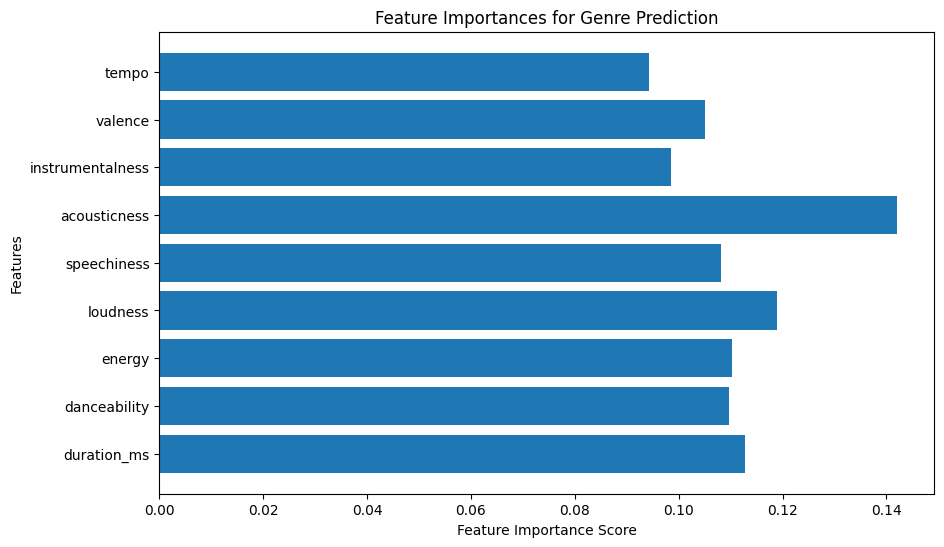

In [181]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

le = LabelEncoder()
features_df['track_genre_encoded'] = le.fit_transform(features_df['track_genre'])

X = features_df[['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']].to_numpy()
y = features_df['track_genre_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo'], feature_importances):
    print(f"\t- {feature}: {importance}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo'], feature_importances)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importances for Genre Prediction')
plt.show()


### Principal Component Analysis (PCA) for Feature Reduction
This code snippet demonstrates how to apply Principal Component Analysis (PCA) to reduce the dimensionality of the feature space. It uses the selected features to fit a PCA model and then visualizes the explained variance ratio for each principal component. Additionally, it displays a bar plot of the feature importances based on the PCA components.

Explained variance ratio of each component: [0.36138576 0.14372026 0.10122781 0.09961933 0.08170149 0.07135925
 0.06070573 0.04591632 0.02374261 0.01062146]


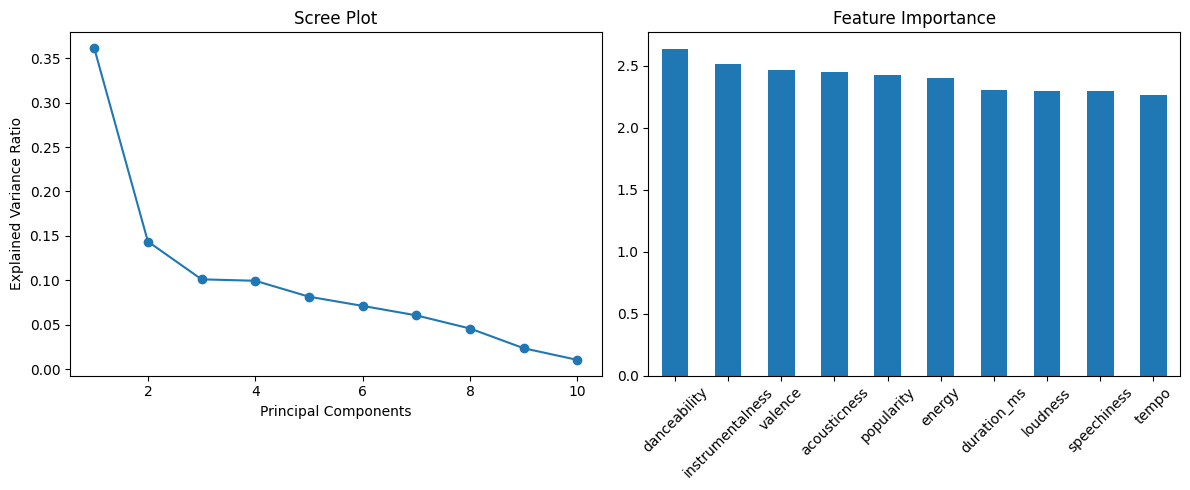

CPU times: user 443 ms, sys: 1.93 s, total: 2.38 s
Wall time: 282 ms


In [182]:
%%time
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA

# Numeric features for PCA
numeric_features = ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']
features_df = features_df[numeric_features]

# Scale your features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(features_df)

# Fit PCA
pca = PCA(n_components=len(features_df.columns))
pca.fit(df_scaled)

# Show the explained variance ratio for each principal component
explained_var_ratios = pca.explained_variance_ratio_
print("Explained variance ratio of each component:", explained_var_ratios)

# --------- Visualizations ---------
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot of Explained Variance Ratio
axes[0].plot(np.arange(1, len(explained_var_ratios) + 1), explained_var_ratios, marker='o')
axes[0].set_xlabel('Principal Components')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plot')

# Feature Importance Bar Plot
feature_contributions = pd.DataFrame(pca.components_, columns=features_df.columns)
feature_importances = feature_contributions.abs().sum(axis=0).sort_values(ascending=False)
feature_importances.plot(kind='bar', ax=axes[1], title='Feature Importance')

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## Exploring Louvain Algorithm using Python-Louvain Library

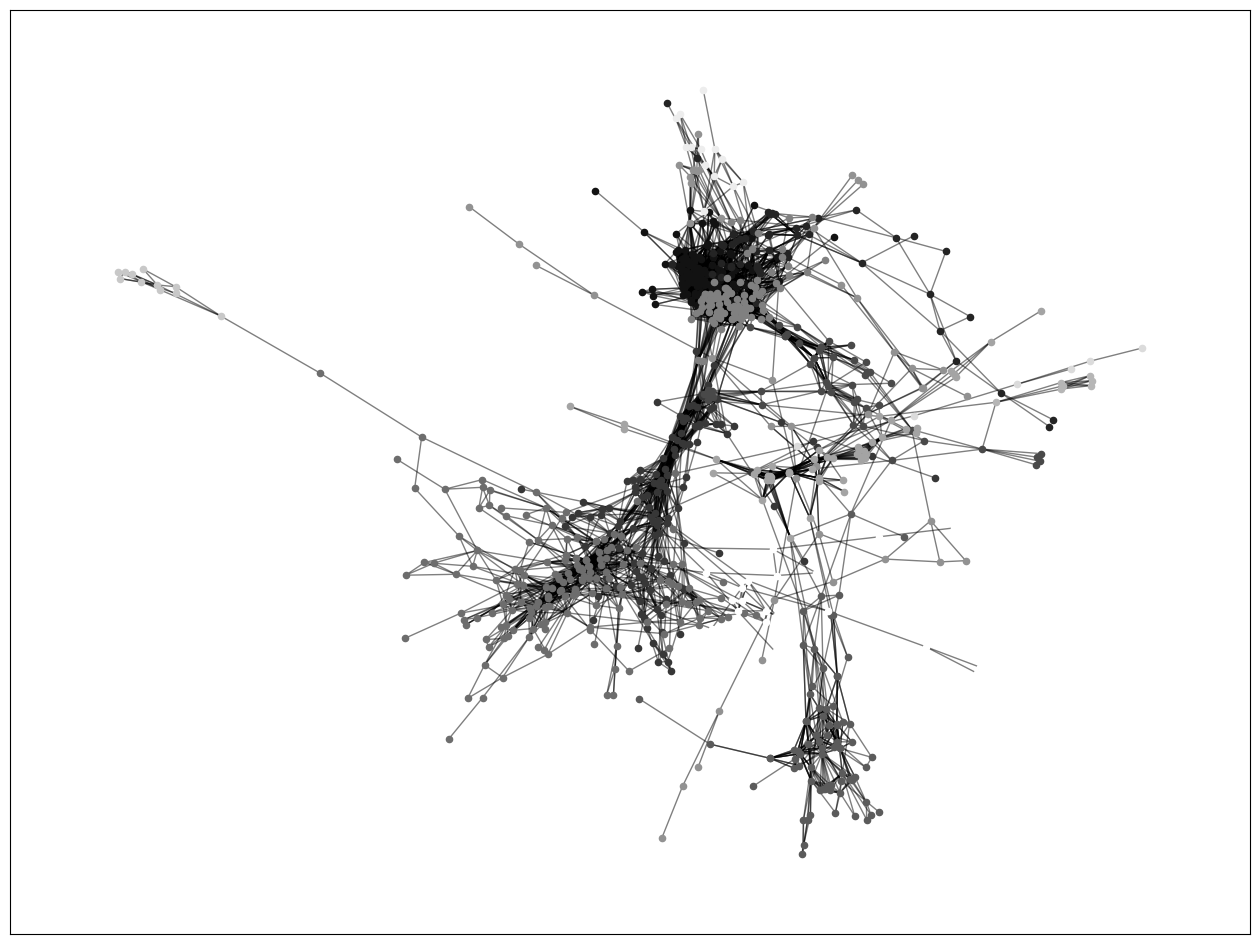

In [179]:
# !pip install python-louvain
import community as community_louvain


def apply_louvain(G):
    partition = community_louvain.best_partition(G)
    pos = nx.spring_layout(G)
    cmap = plt.cm.viridis
    size = float(len(set(partition.values())))
    count = 0
    plt.figure(figsize=(16, 12))
    for com in set(partition.values()):
        count += 1
        list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size=20,
                               node_color=str(count / size), cmap=cmap)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.show()


apply_louvain(G_filtered_largest_gcc)


## Recommendations for Improving Community Detection:
- **Similarity Matrix Algorithms**: Beyond cosine and pearson coefficient similarity, exploring other metrics that may capture more nuanced relationships between tracks could lead to better community structures. For example, incorporating collaborative filtering techniques or graph embeddings might enhance the network's representation of track similarities.
- **Edge Weight Consideration**: Giving importance to the weight of edges (in this case, the similarity score between tracks) can help in identifying stronger communities. Algorithms that can prioritize high-weight edges can detect more meaningful clusters.
- **Graph Preprocessing**: Removing outliers or nodes with very low degrees can sometimes improve community detection by focusing the algorithm on the most significant relationships in the network.
- **Hyperparameter Tuning**: Experimenting with different hyperparameters in community detection algorithms, such as resolution parameters in Louvain or edge betweenness thresholds in Girvan-Newman, can help optimize the detection of meaningful communities.
    - **Modularity Optimization**: Continuously measuring and optimizing modularity or other quality functions can help in finding the partition that best represents the structure of the network
    - **Resolution Parameter Tuning**: For methods like the Louvain algorithm, tuning the resolution parameter can greatly affect community sizes. Higher resolution parameters may lead to smaller, more refined communities, while lower resolutions may merge smaller communities into larger ones.
- **Benchmarking with Ground Truth**: Using known labels (e.g., genres) to benchmark the results can guide adjustments to the algorithm for improved performance.
    